<a href="https://colab.research.google.com/github/DavidMartinezGonzalez/TutorialOnNeuralVocoders/blob/main/chapter_2_DSP_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome

This is the hands-on session for ICASSP 2022 short course **Inclusive Neural Speech Synthesis**, **LECTURE 1, neural vocoder**.

Click [HERE](https://colab.research.google.com/drive/1EO-ggi1U9f2zXwTiqg7AEljVx11JKta7?usp=sharing) to go back to the entry point of this hands-on session.

## About this notebook

In this notebook, we will cover a few digital signal/speech processing tools:
1. Waveform pre-emphasis (Sec.2)
2. Waveform companding using $\mu$-law (Sec.3)
3. Waveform framing and overlap-add method (Sec.4)
4. Sine waveform generator (Sec.5)

Many neural vocoders use the above tools.

Before diving into Sec.2, let's recap the basic waveform I/O tools.

## Preparation

This hands-on session is based on Python (Numpy & Scipy) and Pytorch, and dependency should have been provided by the Colab runtime.

We only need to download some pre-trained models and example data:
(FYI: when the virtual runtime machine on Colab is released and reallocated, we need to download the file again)

In [ ]:
!echo "Download external zip "
!wget --quiet --show-progress -O iNSS.zip https://www.dropbox.com/sh/bua2vks8clnl2ha/AABxjrZhQBRM1YEekjWs8Pl2a/iNSS
!echo "Unzip files"
!unzip -q -o iNSS.zip -x / -d /content
!if [ -d "/content/data_models" ]; then echo "Done"; else echo "Please contact with the author"; fi

Download external zip 
iNSS.zip            100%[===================>] 347.31M  54.3MB/s    in 7.3s    
Unzip files
Done


In [ ]:
# for convenience, define a path to the folder on Google Colab runtime
g_workpath = '/content'

# Sec.1 Recap Python I/O for Waveform

In c1_basis.ipynb, we covered the Python tools to read and write the waveform data:
1. We assume that the waveform on the disk is in WAV PCM 16bits format (32bits also OK);
2. We use [scipy.io.wavfile](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html) to read and write them;
3. We provide simple wrappers over scipy.io.wavfile for this hands-on session. They are in `/content/tool_lib.py`
  * `sr, wav_data = waveReadAsFloat(wav_path)`: read waveform file and return sampling rate (`int`) and wav form data (`np.float32`);
  * `waveFloatToPCMFile(wav_data, wav_path, sr)`: write `wav_data` (`np.float32`) with the specified sampling rate into `wav_path` as a WAV PCM 16bits file;

Two new small tools are:
1. A wrapper `tool_lib.spec_amplitude` to compute the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of a waveform;
2. Simple wrappers in `plot_lib` to plot figures using [matplotlib](https://matplotlib.org/). They are in `/content/plot_lib.py`

We will use these tools in the rest of this notebook.

If you are interested, please check their source code.

In [ ]:
import os
import matplotlib.pyplot as plt
import tool_lib
import plot_lib


# Load waveform data
wavfile_path = os.path.join(g_workpath, 'data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav')
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)
# Write waveform dat
# (here we will skip it)
#
# wavefile_outputpath = './temp.wav'
# waveFloatToPCMFile(wave_data, wavefile_outputpath, sr=sampling_rate)


# check the data shape
print("The loaded waveform array has shape: ", wave_data.shape)
print("Its data dtype is ", wave_data.dtype)
print("Its sampling rate is {:d} Hz".format(sampling_rate))


The loaded waveform array has shape:  (44241,)
Its data dtype is  float32
Its sampling rate is 16000 Hz


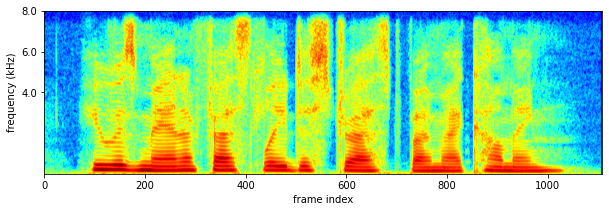

In [ ]:

# Visualize the spectrogram
#  FFT bins
fft_bins = 4096
#  frame shift (number of waveform sampling points)
frame_shift = 40
#  frame_length (number of waveform sampling points)
frame_length = 240

# get the spectrogram
spectrogram = tool_lib.spec_amplitude(
    wave_data, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)

# plot the spectrogram
#  get the fig and axis handler
fig = plt.figure(figsize=(10,3));
axis = fig.add_subplot(111);
#  plot using the wrapper
plot_lib.plot_spectrogram(spectrogram, fig, axis,
                          xlabel="frame index", ylabel="frequency (kHz)",
                          sampling_rate = sampling_rate);

In [ ]:
# Play the sound
import IPython.display
IPython.display.Audio(wave_data, rate=sampling_rate)

# Sec.2 Waveform pre-emphasis and de-emphasis


## Sec.2.1 Equation in textbook

Reference:
1. Equation (5.1) in [HTKBook](https://www.danielpovey.com/files/htkbook.pdf)
2. Official doc of [Librosa](https://librosa.org/doc/0.9.1/generated/librosa.effects.preemphasis.html#librosa-effects-preemphasis)
3. Online course by Prof. Tom Bäckström  ([link](https://wiki.aalto.fi/display/ITSP/Pre-emphasis))

The motivation is "to compensate for the average spectral shape ... which emphasizes higher frequencies" (see ref.3 above). This is recommended in many DSP tool chains. In the last step, we may need to de-emphasize the data.

```sh
        --------------     -----------------    --------------
wav --> |pre-emphasis| --> |other DSP tools| -->| de-emphais | --> processed wave
        --------------     -----------------    --------------
```



Let $x_t$ denote the $t$-th waveform sampling point, and $n\in\{1, 2, \cdots, T\}$. Pre-emphasis and de-emphasis can be done by:
 * Pre-emphasis: $\widehat{x}_t = x_t - \alpha * x_{t-1}$, where $x_{<1}=0$
 * De-emphasis: $x_t = \widehat{x}_t + \alpha * {x}_{t-1}$, where $x_{<1}=0$

$\alpha$ is the pre-emphasis coefficient. We set $\alpha = 0.97$, following the practice in HTKBook.


Pre-emphasis can be used to, for example, process the target waveform when training WaveNet and LPCNet.

## Sec.2.2 Python Numpy Implementation

Notice that $x_1$ is indexed as x[0] in Numpy array.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tool_lib
import plot_lib

def _preemphasis(wav, coef=0.97):
    """
    input: wav, np.array, (length, )
    output: wav_tmp, np.array, (length, )
    """
    wav_tmp = np.zeros_like(wav) + wav
    wav_tmp[1:] = wav_tmp[1:] - coef * wav_tmp[:-1]
    return wav_tmp

def _deemphasis(wav, coef=0.97):
    """
    input: wav, np.array, (length, )
    output: out, np.array, (length, )
    """
    out = np.zeros_like(wav) + wav
    for idx in range(1, wav.shape[0]):
        out[idx] = out[idx] + coef * out[idx-1]
    return out

## Sec.2.3 Example

In [ ]:
# Example usage

# Load waveform data
wavfile_path = os.path.join(g_workpath, 'data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav')
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)

coef = 0.97
# pre-emphasis
wav_preemphasis = _preemphasis(wave_data, coef)
# de-emphasis (reverse it back)
wav_demphasis = _deemphasis(wav_preemphasis, coef)

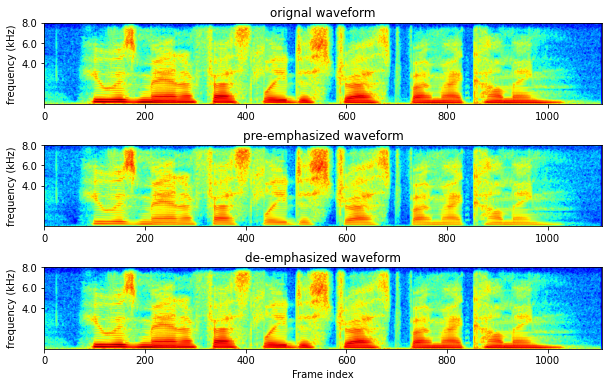

In [ ]:
# Let's compare the spectrogram of the waveforms

# FFT bins
fft_bins = 4096
#  frame shift (number of waveform sampling points)
frame_shift = 40
#  frame_length (number of waveform sampling points)
frame_length = 240

# get the spectrogram
spec_wave_data = tool_lib.spec_amplitude(
    wave_data, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)
spec_wave_preemph = tool_lib.spec_amplitude(
    wav_preemphasis, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)
spec_wave_deemph = tool_lib.spec_amplitude(
    wav_demphasis, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)

# plot
#  to unify the imshow scale, we need to get the min and max
vmin = min([x.min() for x in [spec_wave_data, spec_wave_preemph, spec_wave_deemph]])
vmax = max([x.max() for x in [spec_wave_data, spec_wave_preemph, spec_wave_deemph]])

fig = plt.figure(figsize=(10, 6))
axis = fig.add_subplot(311);
plot_lib.plot_spectrogram(spec_wave_data, fig, axis, "", "frequency (kHz)",
                          sampling_rate = sampling_rate,
                          title='orignal waveform', minmax=[vmin, vmax])
axis=fig.add_subplot(312);
plot_lib.plot_spectrogram(spec_wave_preemph, fig, axis, "", "frequency (kHz)",
                          sampling_rate = sampling_rate,
                          title='pre-emphasized waveform', minmax=[vmin, vmax])
axis=fig.add_subplot(313);
plot_lib.plot_spectrogram(spec_wave_deemph, fig, axis, "Frame index",
                          "frequency (kHz)", sampling_rate = sampling_rate,
                          title='de-emphasized waveform', minmax=[vmin, vmax])
fig.subplots_adjust(hspace=0.5)


Compared with original and de-emphasized waveforms, the pre-emphasized waveform has less energy in the low-frequency band (i.e., the part below 4 kHz is less red).

Let's listen to the audio.

In [ ]:
# Play the sound
import IPython.display
IPython.display.display("Original waveform")
IPython.display.display(IPython.display.Audio(wave_data, rate=sampling_rate))
IPython.display.display("Pre-emphasized waveform")
IPython.display.display(IPython.display.Audio(wav_preemphasis, rate=sampling_rate))
IPython.display.display("De-emphasized waveform")
IPython.display.display(IPython.display.Audio(wav_demphasis, rate=sampling_rate))

'Original waveform'

'Pre-emphasized waveform'

'De-emphasized waveform'

Text(0.5, 0, 'Frequency (kHz)')

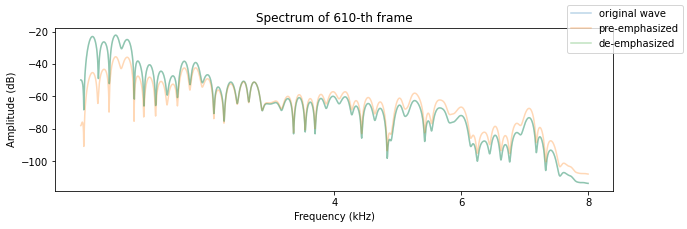

In [ ]:
# We can plot one specific frame

# plot one frame
spec_idx = 610

fig=plt.figure(figsize=(10, 3));
axis=fig.add_subplot(111);
axis.plot(spec_wave_data[:, spec_idx], alpha=0.3)
axis.plot(spec_wave_preemph[:, spec_idx], alpha=0.3)
axis.plot(spec_wave_deemph[:, spec_idx], alpha=0.3)
fig.legend(['original wave', 'pre-emphasized', 'de-emphasized'])
axis.set_title("Spectrum of {:d}-th frame".format(spec_idx));
axis.set_ylabel('Amplitude (dB)')
xticks = [(fft_bins//2+1)//2, (fft_bins//2+1)//4*3, (fft_bins//2+1)]
xticklabels = [sampling_rate//4, sampling_rate//2//4*3, sampling_rate//2]
xticklabels = ['{:d}'.format(int(x/1000)) for x in xticklabels]
axis.set_xticks(xticks)
axis.set_xticklabels(xticklabels)
axis.set_xlabel('Frequency (kHz)')

# 'original' overlaps with 'de-emphasized',
# while 'pre-emphasized' emphasises higher frequencies

# Sec.3 Waveform companding


## Sec.3.1 Explanation


To quote the [Wikipedia](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm):
> In analog systems, this can increase the signal-to-noise ratio (SNR) achieved during transmission; in the digital domain, it can reduce the quantization error (hence increasing the signal-to-quantization-noise ratio). These SNR increases can be traded instead for reduced bandwidth for equivalent SNR.


For explanation, we consider `companding` and `quantization` as separate operations, and quantization is conducted after companding. The input to and output from `companding` are continuous-valued waveform data.

```sh
                          ------------ wrapper 1 -----------  
        --------------    | ------------    -------------- |
wave -->|pre-emphasis| -->| |companding|--->|quantization| | --> quantized wave
        --------------    | ------------    -------------- |
                          ----------------------------------

                  ---------- Wrapper 2 -------------
                  | ---------------    ----------- |     -------------    
quantized wave -> | |inverse-quan.|--->|expansion| | --> |de-emphasis| --> wave
                  | ---------------    ----------- |     -------------    
                  ----------------------------------
```

Here we focus on the $\mu$-law companding since it is used in WaveNet, LPCNet, and other neural vocoders.

Note that all neural vocoders use companding and quantization.

In the implementation below, however, we wrap them together.

## Sec.3.2 Python Numpy Implementation



In [ ]:
import numpy as np

def mulaw_encode(x, n_quan_bins, scale_to_int=True):
    """x_mu = mulaw_encode(x, n_quan_bins, scale_to_int=True)

    mu-law companding

    input
    -----
       x: np.array, float-valued waveforms in (-1, 1)
       n_quan_bins (int): Number of quantization levels
       scale_to_int: Bool
         True: scale mu-law to int
         False: return mu-law in (-1, 1)

    output
    ------
       x_mu: np.array, mulaw companded wave
    """
    # equation in https://en.wikipedia.org/wiki/%CE%9C-law_algorithm
    mu = n_quan_bins - 1.0
    x_mu = np.sign(x) * np.log1p(mu * np.abs(x)) / np.log1p(mu)

    # quantize mu-law waveform if necessary
    if scale_to_int:
        x_mu = np.array((x_mu + 1) / 2 * mu + 0.5, dtype=np.int32)
    return x_mu

def mulaw_decode(x_mu, n_quan_bins, input_int=True):
    """mulaw_decode(x_mu, n_quan_bins, input_int=True)

    mu-law decoding

    input
    -----
      x_mu: np.array, mu-law waveform
      n_quan_bins: int, Number of levels
      input_int: Bool
        True: convert x_mu (int) from int to float, before mu-law decode
        False: directly decode x_mu (float)

    output
    ------
        x: np.array, waveform from mulaw decoding
    """
    mu = n_quan_bins - 1.0

    # whether input is quantized?
    if input_int:
        x = x_mu / mu * 2 - 1.0
    else:
        x = x_mu

    # mu-law expansion
    x = np.sign(x) * (np.exp(np.abs(x) * np.log1p(mu)) - 1.0) / mu
    return x

## Sec.3.3 Example

In [ ]:
# Example usage

# Load waveform data
wavfile_path = os.path.join(g_workpath, 'data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav')
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)

# number of bits for companding (or quantization)
num_bit = 8

# number of quantization levelsb
num_quantization_level =2 ** num_bit

In [ ]:
# companding only
mulaw_data_float = mulaw_encode(wave_data, num_quantization_level, scale_to_int=False)

# companding + quantization
mulaw_data_int = mulaw_encode(wave_data, num_quantization_level, scale_to_int=True)
print("Quantized mu-law data: min: {:d}, max:{:d}".format(mulaw_data_int.min(), mulaw_data_int.max()))

Quantized mu-law data: min: 21, max:245


In [ ]:
#  expansion from companded signal
de_mulaw_wav_fromfloat = mulaw_decode(mulaw_data_float, num_quantization_level, input_int=False)

#  inverse quantization + expansion
de_mulaw_wav_fromint = mulaw_decode(mulaw_data_int, num_quantization_level, input_int=True)

We now plot the figures using companded and expanded waveforms.

Note that the STFT API here requires continuous-valued waveform data as input, we cannot directly feed in the quantized waveform (int).


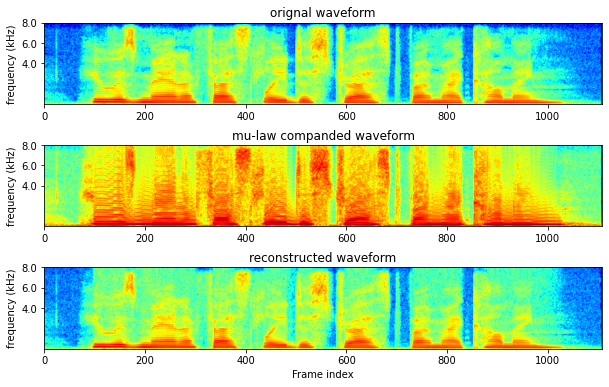

In [ ]:
# FFT bins
fft_bins = 4096
#  frame shift (number of waveform sampling points)
frame_shift = 40
#  frame_length (number of waveform sampling points)
frame_length = 240

# get the spectrogram
spec_wave_data = tool_lib.spec_amplitude(
    wave_data, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)
spec_wave_mu_com = tool_lib.spec_amplitude(
    mulaw_data_float, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)
spec_wave_mu_exp = tool_lib.spec_amplitude(
    de_mulaw_wav_fromint, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)

# plot
#  to unify the imshow scale, we need to get the min and max
vmin = min([x.min() for x in [spec_wave_data, spec_wave_mu_com, spec_wave_mu_exp]])
vmax = max([x.max() for x in [spec_wave_data, spec_wave_mu_com, spec_wave_mu_exp]])

fig = plt.figure(figsize=(10, 6))
axis = fig.add_subplot(311);
plot_lib.plot_spectrogram(spec_wave_data, fig, axis, "", "frequency (kHz)",
                          sampling_rate = sampling_rate,
                          title='orignal waveform', minmax=[vmin, vmax])
axis=fig.add_subplot(312);
plot_lib.plot_spectrogram(spec_wave_mu_com, fig, axis, "", "frequency (kHz)",
                          sampling_rate = sampling_rate,
                          title='mu-law companded waveform', minmax=[vmin, vmax])
axis=fig.add_subplot(313);
plot_lib.plot_spectrogram(spec_wave_mu_exp, fig, axis, "Frame index",
                          "frequency (kHz)", sampling_rate = sampling_rate,
                          title='reconstructed waveform', minmax=[vmin, vmax])
fig.subplots_adjust(hspace=0.5)


In [ ]:
# Play the sound
import IPython.display
IPython.display.display("Original waveform")
IPython.display.display(IPython.display.Audio(wave_data, rate=sampling_rate))
IPython.display.display("Mu-law companded waveform (be careful to the loud volume)")
IPython.display.display(IPython.display.Audio(mulaw_data_float, rate=sampling_rate))
IPython.display.display("Reconstructed waveform")
IPython.display.display(IPython.display.Audio(de_mulaw_wav_fromint, rate=sampling_rate))

'Original waveform'

'Mu-law companded waveform (be careful to the loud volume)'

'Reconstructed waveform'

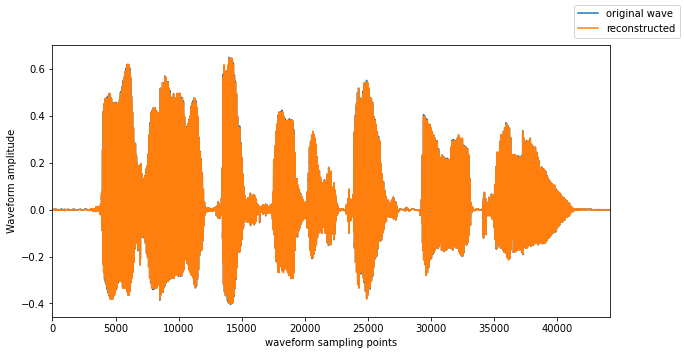

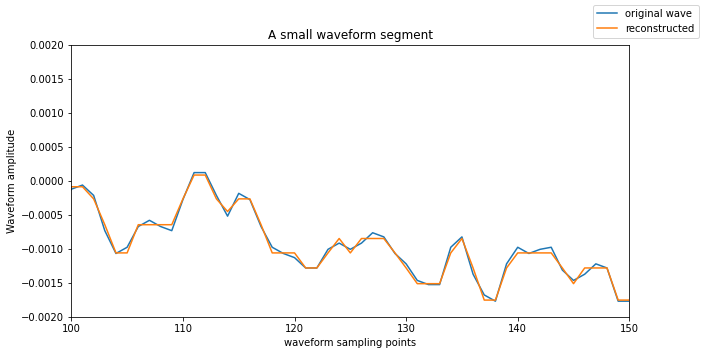

In [ ]:
# Plot the waveform
xlabel = 'waveform sampling points'
ylabel = 'Waveform amplitude'
fig=plt.figure(); axis=fig.add_subplot(111);
plot_lib.plot_signal(wave_data, fig, axis)
#plot_lib.plot_signal(mulaw_data_float, fig, axis)
plot_lib.plot_signal(de_mulaw_wav_fromint, fig, axis, xlabel, ylabel)
#axis.set_xlim(5000, 5500)
#fig.legend(['original wave', 'mu-law companded', 'reconstructed'], loc=1)
fig.legend(['original wave', 'reconstructed'], loc=1)

# Look carefully
fig=plt.figure(); axis=fig.add_subplot(111);
plot_lib.plot_signal(wave_data, fig, axis)
plot_lib.plot_signal(de_mulaw_wav_fromint, fig, axis, xlabel, ylabel)
axis.set_xlim(100, 150)
axis.set_ylim(-0.002, 0.002)
axis.set_title("A small waveform segment");
fig.legend(['original wave', 'reconstructed'], loc=1)

From the second figure you may see the difference caused by quantization

# Sec.4 Waveform framing (windowing) & overlap-add


## Sec.4.1 Explanation

Waveform framing or windowing is to truncate a long waveform into small overlapped segments (i.e., frames), while overlap-add is the way to construct the waveform from the segments.

<img src="https://wiki.aalto.fi/download/attachments/148294912/ola2-1.png?version=1&modificationDate=1552662168647&api=v2" width="500">


(Image from Dr. Tom Bäckström [course on speech processing](https://wiki.aalto.fi/display/ITSP/Preface).)


This set of operations is very useful for neural vocoders:
1. for most neural vocoders, framing is necessary when extracting the input acoustic features from waveforms;
2. for some vocoders (e.g., the voice converter model called [Blow](https://github.com/joansj/blow)), overlap-add is used to reconstruct the waveform;


Three (hyper-)parameters are important:
1. frame length: length of each frame (or window);
2. frame shift: how much do we shift the window when extracting the next frame;
3. window: which type of window is applied to each frame (see more on [Wikipedia](https://en.wikipedia.org/wiki/Window_function)).




## Sec.4.2 Pytorch Module definition


Here, we explain a naive Pytorch implementation.  Numpy re-implementation should be straightforward, and we will cover it later.


Basic usage:
1. Framed_waveform <- OverlapAdder.forward(Original_waveform)
2. Reconstructed_waveform <- OverlapAdder.reverse(Framed_waveform)

Original and reconstructed waveforms are in shape `(batchsize, waveform_length, dim=1)`.

Framed waveform buffer is a tensor in shape `(batchsize, number_of_frames, frame_length)`


In [ ]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func

class OverlapAdder(torch_nn.Module):
    """OverlapAdder
    """
    def __init__(self, fl, fs, flag_win_analysis=True):
        """OverlapAdder(flag_windowing_before=True)
        Args
        ----
          fl: int, frame length
          fs: int, frame shift
          flag_win_analysis: bool (default True)
              True: apply windowing during analysis
              False: apply windowing during synthesis
        """
        super(OverlapAdder, self).__init__()
        self.fl = fl
        self.fs = fs
        self.flag_win_ana = flag_win_analysis

        # assume even
        self.m_win = torch_nn.Parameter(torch.hann_window(self.fl))
        return

    def get_frame_num(self, wav_length):
        """frame_num = get_frame_num(wav_length)
        wav_length: int, waveform length
        frame_num: int, number of frames
        """
        return (wav_length - self.fl) // self.fs + 1

    def get_wavlength(self, frame_num):
        """wav_length = get_wavlength(self, frame_num)
        wav_length: int, waveform length
        frame_num: int, number of frames
        """
        return (frame_num - 1) * self.fs + self.fl

    def forward(self, x):
        """OverlapAdder(x)

        input
        -----
          x: tensor, (batch, length, 1)

        output
        ------
          y: tensor, (batch, frame_num, frame_length)
        """
        frame_num = self.get_frame_num(x.shape[1])

        # (batch, num_patches, 1, patch_size)
        # num_patches = (length - length) // shift + 1
        # and copy the data
        # note that unfold put each patch as the last dimension
        # x_tmp (batch, frame_num, 1, frame_length)
        x_tmp = x.unfold(1, self.fl, self.fs)

        # apply window
        if self.flag_win_ana:
            x_tmp = x_tmp * self.m_win

        # (batch, frame_num, frame_length)
        return x_tmp.view(x.shape[0], x_tmp.shape[1], -1)

    def reverse(self, x_framed, flag_scale=False):
        """OverlapAdder(x)

        input
        -----
          x: tensor, (batch, frame_num, frame_length)
          flag_scale: bool, whether scale the ampltidue to (-1, 1)
                      default False
        output
        ------
          y: tensor, (batch, length, 1)
        """
        batch, frame_num, frame_len = x_framed.shape
        x_len = self.get_wavlength(frame_num)
        x_buf = torch.zeros(
            [batch, x_len], device=x_framed.device, dtype=x_framed.dtype)
        x_win = torch.zeros_like(x_buf)

        for idx in range(frame_num):
            sdx = idx * self.fs
            edx = sdx + self.fl
            x_win[:, sdx:edx] += self.m_win
            if not self.flag_win_ana:
                x_buf[:, sdx:edx] += x_framed[:, idx] * self.m_win
            else:
                x_buf[:, sdx:edx] += x_framed[:, idx]
        # assume the overlapped window has a constant amplitude
        x_buf = x_buf / x_win.mean()

        # normalize the amplitude between (-1, 1)
        if flag_scale:
            # if input is between (-1, 1), there is no need to
            # do this normalization
            x_buf = x_buf / (x_buf.abs().max())
        return x_buf.unsqueeze(-1)


## Sec.4.2 Example

Let's try with one example

In [ ]:
# Example usage

# Load waveform data
wavfile_path = os.path.join(g_workpath, 'data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav')
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)
# convert numpy array to tensor in shape (1, wavelength, 1)
wave_data_tensor = torch.tensor(wave_data).unsqueeze(0).unsqueeze(-1)

# Create a framing and overlap adder
frame_length = 320
frame_shift = 80

# Claim a overlapAdder
m_overlapadder = OverlapAdder(frame_length, frame_shift)


In [ ]:
# Framing
with torch.no_grad():
    framed_wave_tensor = m_overlapadder(wave_data_tensor)


# Overlap and add, i.e., reconstructing the original waveforms
with torch.no_grad():
    reconstructed_wave_tensor = m_overlapadder.reverse(framed_wave_tensor)


print("Input waveform tensor has shape", wave_data_tensor.shape)
print("Framed waveform tensor has shape", framed_wave_tensor.shape)
print("Reconstructed waveform tensor has shape", reconstructed_wave_tensor.shape)

Input waveform tensor has shape torch.Size([1, 44241, 1])
Framed waveform tensor has shape torch.Size([1, 550, 320])
Reconstructed waveform tensor has shape torch.Size([1, 44240, 1])


Notice how framed waveform has 550 frames, where each frame contains 320 waveform sampling points.

We can compare the frames with the original waveform

### Plot individual frames


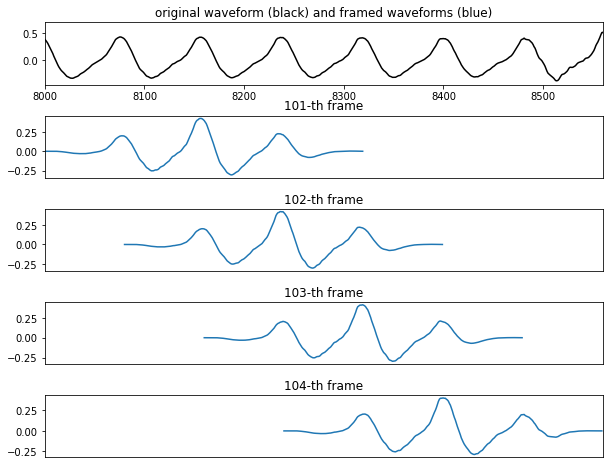

In [ ]:
# Let's plot a few frames

# function to the time index of one frame
def frame_time_idx_range(frame_idx, frame_length, frame_shift):
    # a, b = frame_time_idx_range(frame_idx, frame_length, frame_shift)
    #  a: start time index of the frame
    #  b: end time index of the frame
    return frame_idx * frame_shift, frame_idx * frame_shift + frame_length

# plot these frames
frame_indices = [100, 101, 102, 103]
#  the time range to plot the waveforms
plot_xlim = [frame_time_idx_range(frame_indices[0], frame_length, frame_shift)[0],
             frame_time_idx_range(frame_indices[-1], frame_length, frame_shift)[-1]]


# plot the whole waveform
length = wave_data.shape[0]
time_idx = np.arange(length)
fig=plt.figure(figsize=(10, 8));
axis=fig.add_subplot(len(frame_indices)+1, 1, 1);
axis.plot(time_idx, wave_data, color='k')
axis.set_title('original waveform (black) and framed waveforms (blue)')
axis.set_xlim(plot_xlim)

# plot a few frames
for figure_idx, frame_idx in enumerate(frame_indices):
    axis=fig.add_subplot(len(frame_indices)+1, 1, figure_idx + 2);
    frame_start, frame_end = frame_time_idx_range(frame_idx, frame_length, frame_shift)
    axis.plot(np.arange(frame_start, frame_end), framed_wave_tensor[0, frame_idx].numpy())
    axis.set_title("{:d}-th frame".format(frame_idx+1));
    axis.set_xticks([])
    axis.set_xlim(plot_xlim)
fig.subplots_adjust(hspace=0.5)

Now we can try to overlap and add these frames

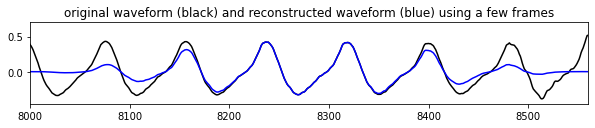

In [ ]:
# This is basically what OverlapAdder.reverse() does

# create a buffer to store the overlapped waveform
reconstructed_buffer = np.zeros(length)

# overlap & add
for _, frame_idx in enumerate(frame_indices):
    frame_start, frame_end = frame_time_idx_range(frame_idx, frame_length, frame_shift)
    reconstructed_buffer[frame_start : frame_end] += framed_wave_tensor[0, frame_idx].numpy()

# re-scale the ampltiude
reconstructed_buffer = reconstructed_buffer/2

# plot
fig=plt.figure(figsize=(10, 1.5)); axis=fig.add_subplot(111);
axis.plot(time_idx, wave_data, color='k')
axis.set_title('original waveform (black) and reconstructed waveform (blue) using a few frames')
axis.set_xlim(plot_xlim)
axis.plot(reconstructed_buffer, color='b')


Notice that the beginning and ending part of the reconstructed waveform (in blue) has a smaller amplitude. This is due to the window function applied.

The effect is negligible when we do overlap-add on all the frames.

### Plot the whole waveform

'Original waveform'

'Reconstructed waveform'

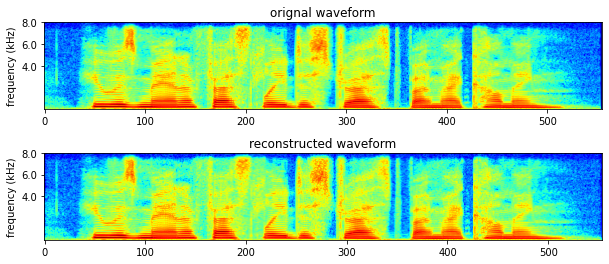

In [ ]:
# Let's compare the original and reconstructed waveforms

# convert tensor to numpy array for plotting
framed_wave = framed_wave_tensor.numpy()[0]
reconstructed_wave = reconstructed_wave_tensor.numpy()[0, :, 0]

# FFT bins
fft_bins = 4096
#  frame shift (number of waveform sampling points)
#frame_shift = 40
#  frame_length (number of waveform sampling points)
#frame_length = 240

# get the spectrogram
spec_wave_data = tool_lib.spec_amplitude(
    wave_data, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)
spec_wave_recon = tool_lib.spec_amplitude(
    reconstructed_wave, fft_bins=fft_bins, frame_shift=frame_shift,
    frame_length=frame_length)

# plot
#  to unify the imshow scale, we need to get the min and max
vmin = min([x.min() for x in [spec_wave_data, spec_wave_recon]])
vmax = max([x.max() for x in [spec_wave_data, spec_wave_recon]])

fig = plt.figure(figsize=(10, 4))
axis = fig.add_subplot(211);
plot_lib.plot_spectrogram(spec_wave_data, fig, axis, "", "frequency (kHz)",
                          sampling_rate = sampling_rate,
                          title='orignal waveform', minmax=[vmin, vmax])
axis=fig.add_subplot(212);
plot_lib.plot_spectrogram(spec_wave_recon, fig, axis, "", "frequency (kHz)",
                          sampling_rate = sampling_rate,
                          title='reconstructed waveform', minmax=[vmin, vmax])
fig.subplots_adjust(hspace=0.5)

IPython.display.display('Original waveform')
IPython.display.display(IPython.display.Audio(wave_data, rate=sampling_rate))
IPython.display.display('Reconstructed waveform')
IPython.display.display(IPython.display.Audio(reconstructed_wave, rate=sampling_rate))

## Sec.4.3 A special example

To better illustrate the framing and overlap-add, we can feed in a "waveform" with a constant value of 1.0.



In [ ]:
# Let's use a constant-valued signal as example
length = 1000
example_wav_tensor = torch.ones([1, length, 1])

# Create a framing and overlap adder 1
frame_length1 = 320
frame_shift1 = 80
m_overlapadder1 = OverlapAdder(frame_length1, frame_shift1)

# Create a framing and overlap adder 2
frame_length2 = 320
frame_shift2 = 160
m_overlapadder2 = OverlapAdder(frame_length2, frame_shift2)


with torch.no_grad():
    # framed wave
    framed_wave_tensor1 = m_overlapadder1(example_wav_tensor)
    framed_wave_tensor2 = m_overlapadder2(example_wav_tensor)

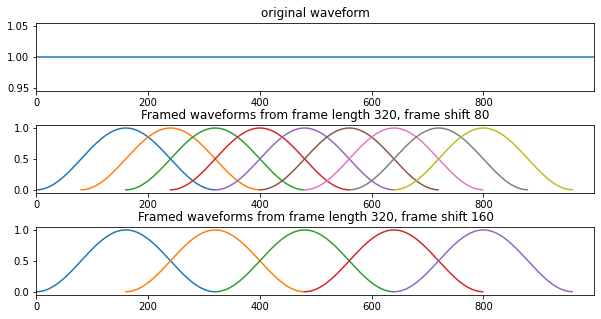

In [ ]:
# plot figures
def frame_time_idx_range(frame_idx, frame_length, frame_shift):
    # return the start and end time index of the frame
    return frame_idx * frame_shift, frame_idx * frame_shift + frame_length

# whole waveform
time_idx = np.arange(length)
fig=plt.figure(); axis=fig.add_subplot(311);
axis.plot(time_idx, example_wav_tensor.numpy()[0, :, 0])
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('original waveform')

# plot each frames from overlapp adder 1
frame_num1 = framed_wave_tensor1.shape[1]
axis=fig.add_subplot(312);
for frame_idx in np.arange(frame_num1):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length1, frame_shift1)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor1[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length1, frame_shift1))


# plot each frames from overlapp adder 2
frame_num2 = framed_wave_tensor2.shape[1]
axis=fig.add_subplot(313);
for frame_idx in np.arange(frame_num2):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length2, frame_shift2)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor2[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length2, frame_shift2))

fig.subplots_adjust(hspace=0.5)

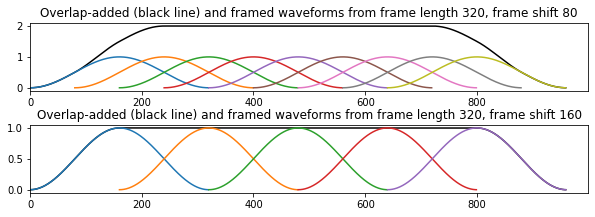

In [ ]:
# Length of reconstructed waveform
#  see OverlapAdder.get_wavlength()
reconstructed_waveform_length1 = (frame_num1 - 1) * frame_shift1 + frame_length1
recon_wave_buffer1 = np.zeros([reconstructed_waveform_length1])

reconstructed_waveform_length2 = (frame_num2 - 1) * frame_shift2 + frame_length2
recon_wave_buffer2 = np.zeros([reconstructed_waveform_length2])


# overlap
# see OverlapAdder.reverse()
for frame_idx in np.arange(frame_num1):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length1, frame_shift1)
    recon_wave_buffer1[start_idx:end_idx] += framed_wave_tensor1[0, frame_idx].numpy()

for frame_idx in np.arange(frame_num2):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length2, frame_shift2)
    recon_wave_buffer2[start_idx:end_idx] += framed_wave_tensor2[0, frame_idx].numpy()


# plot figures for configuration 1
fig=plt.figure(); axis=fig.add_subplot(311);
# plot the overlapped waveform
axis.plot(np.arange(reconstructed_waveform_length1), recon_wave_buffer1, color='k')
# plot each frame for reference
for frame_idx in np.arange(frame_num1):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length1, frame_shift1)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor1[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Overlap-added (black line) and framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length1, frame_shift1))


# plot figures for configuration 1
axis=fig.add_subplot(312);
# plot the overlapped waveform
axis.plot(np.arange(reconstructed_waveform_length2), recon_wave_buffer2, color='k')
# plot each frame for reference
for frame_idx in np.arange(frame_num2):
    start_idx, end_idx = frame_time_idx_range(frame_idx, frame_length2, frame_shift2)
    axis.plot(np.arange(start_idx, end_idx), framed_wave_tensor2[0, frame_idx].numpy())
axis.set_xlim(time_idx[0], time_idx[-1])
axis.set_title('Overlap-added (black line) and framed waveforms from frame length {:d}, frame shift {:d}'.format(frame_length2, frame_shift2))

fig.subplots_adjust(hspace=0.5)

Except for the beginning and end, the waveform can be reconstructed since the overlapped windows sum to a constant value.


This is related to the perfect reconstruction of the overlap-add method, and there is the theory behind that. Please check [the course by CCRMA](https://ccrma.stanford.edu/~jos/sasp/Overlap_Add_Decomposition.html).



# Sec.5 Sine waveform generator


## Sec.5.1 Explanation


Sine waveform generator (i.e., [oscillator in circuit](https://en.wikipedia.org/wiki/Electronic_oscillator)) used in some vocoders. For example, the neural source-filter waveform model uses it to produce the source signal.



## Sec.5.2 Python implementation

Here, we assume that F0=0 Hz denotes being unvoiced.

Let's consider a simple F0 trajectory that gradually increases.


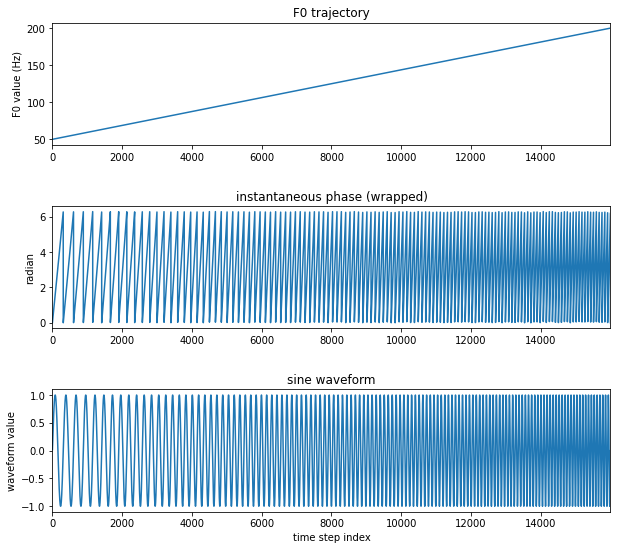

In [ ]:
import numpy as np
import plot_lib


sampling_rate = 16000

# F0 of a chirp signal that goes from 50Hz to 200Hz.
# Assume the output waveform is 1s
f0_values = np.linspace(50, 200, sampling_rate * 1)


# step1. treat F0 as instantaneous frequency
inst_freq = f0_values

# step2. cummulate the instantaneous phase
inst_phase = (np.cumsum(inst_freq)) * 2 * np.pi / sampling_rate
# We can also use this equation to wrap the phase between (0, 2pi)
#  otherwise, inst_phase can be very large
inst_phase = (np.cumsum(inst_freq)  / sampling_rate % 1 ) * 2 * np.pi

# step3. generate the sine waveform, assuming zero phase-offset
sine_wave = np.sin(inst_phase)

fig = plt.figure(figsize=(10, 9));
axis=fig.add_subplot(311)
plot_lib.plot_signal(f0_values, fig, axis, xlabel='',
                     ylabel='F0 value (Hz)', title='F0 trajectory')
axis=fig.add_subplot(312)
plot_lib.plot_signal(inst_phase, fig, axis, xlabel='',
                     ylabel='radian', title='instantaneous phase (wrapped)')
axis=fig.add_subplot(313)
plot_lib.plot_signal(sine_wave, fig, axis, xlabel='time step index',
                     ylabel='waveform value', title='sine waveform')
fig.subplots_adjust(hspace=0.5)

import IPython.display
IPython.display.display(IPython.display.Audio(sine_wave, rate=sampling_rate))

## Sec.5.3 Pytorch Module Definition


The Pytorch module definition is based on the above toy example.

It further considers:

1. Random phase offset (initial phase)
2. Harmonic overtones where F0 is the N times of the input F0
3. Unvoiced regions
4. Amplitude and additive noise
5. Generate sine waveforms in batch mode

In [ ]:
import sys
import numpy as np
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func


class SineGen(torch_nn.Module):
    """ Definition of sine generator
    SineGen(samp_rate, harmonic_num = 0,
            sine_amp = 0.1, noise_std = 0.003,
            voiced_threshold = 0,
            flag_for_pulse=False)

    samp_rate: sampling rate in Hz
    harmonic_num: number of harmonic overtones (default 0)
    sine_amp: amplitude of sine-wavefrom (default 0.1)
    noise_std: std of Gaussian noise (default 0.003)
    voiced_thoreshold: F0 threshold for U/V classification (default 0)
    flag_for_pulse: this SinGen is used inside PulseGen (default False)

    Note: when flag_for_pulse is True, the first time step of a voiced
        segment is always sin(np.pi) or cos(0)
    """
    def __init__(self, samp_rate, harmonic_num = 0,
                 sine_amp = 0.1, noise_std = 0.003,
                 voiced_threshold = 0,
                 flag_for_pulse=False):
        super(SineGen, self).__init__()
        self.sine_amp = sine_amp
        self.noise_std = noise_std
        self.harmonic_num = harmonic_num
        self.dim = self.harmonic_num + 1
        self.sampling_rate = samp_rate
        self.voiced_threshold = voiced_threshold
        self.flag_for_pulse = flag_for_pulse

    def _f02uv(self, f0):
        # generate uv signal
        uv = torch.ones_like(f0)
        uv = uv * (f0 > self.voiced_threshold)
        return uv

    def _f02sine(self, f0_values):
        """ f0_values: (batchsize, length, dim)
            where dim indicates fundamental tone and overtones
        """
        # convert to F0 in rad for discrete time signal.
        # The interger part n can be ignored,
        # because 2 * np.pi * n doesn't affect phase
        rad_values = (f0_values / self.sampling_rate) % 1

        # initial phase noise (no noise for fundamental component)
        rand_ini = torch.rand(f0_values.shape[0], f0_values.shape[2],\
                              device = f0_values.device)
        rand_ini[:, 0] = 0
        rad_values[:, 0, :] = rad_values[:, 0, :] + rand_ini

        # instantaneous phase = torch.cumsum(rad_values, dim=1) * 2 pi
        # sine[t] = sin(instantaneous)
        if not self.flag_for_pulse:
            # for normal case
            sines = torch.sin(torch.cumsum(rad_values, dim=1) *2*np.pi)
        else:
            # If necessary, make sure that the first time step of every
            # voiced segments is sin(pi) or cos(0)
            # This is used for pulse-train generation

            # identify the last time step in unvoiced segments
            uv = self._f02uv(f0_values)
            uv_1 = torch.roll(uv, shifts=-1, dims=1)
            uv_1[:, -1, :] = 1
            u_loc = (uv < 1) * (uv_1 > 0)

            # get the instantanouse phase
            tmp_cumsum = torch.cumsum(rad_values, dim=1)
            # different batch needs to be processed differently
            for idx in range(f0_values.shape[0]):
                temp_sum = tmp_cumsum[idx, u_loc[idx, :, 0], :]
                temp_sum[1:, :] = temp_sum[1:, :] - temp_sum[0:-1, :]
                # stores the accumulation of i.phase within
                # each voiced segments
                tmp_cumsum[idx, :, :] = 0
                tmp_cumsum[idx, u_loc[idx, :, 0], :] = temp_sum

            # rad_values - tmp_cumsum: remove the accumulation of i.phase
            # within the previous voiced segment.
            i_phase = torch.cumsum(rad_values - tmp_cumsum, dim=1)

            # get the sines
            sines = torch.cos(i_phase * 2 * np.pi)
        return  sines


    def forward(self, f0):
        """ sine_tensor, uv = forward(f0)
        input F0: tensor(batchsize, length, dim=1)
                  f0 for unvoiced steps should be 0

        output sine_tensor: tensor(batchsize, length, dim)
        output uv: tensor(batchsize=1, length, 1)
        """
        with torch.no_grad():
            f0_buf = torch.zeros(f0.shape[0], f0.shape[1], self.dim, \
                                    device=f0.device)
            # fundamental component
            f0_buf[:, :, 0] = f0[:, :, 0]
            for idx in np.arange(self.harmonic_num):
                # idx + 2: the (idx+1)-th overtone, (idx+2)-th harmonic
                f0_buf[:, :, idx+1] = f0_buf[:, :, 0] * (idx+2)

            # generate sine waveforms
            sine_waves = self._f02sine(f0_buf) * self.sine_amp

            # generate uv signal
            #uv = torch.ones(f0.shape)
            #uv = uv * (f0 > self.voiced_threshold)
            uv = self._f02uv(f0)

            # noise: for unvoiced should be similar to sine_amp
            #        std = self.sine_amp/3 -> max value ~ self.sine_amp
            #.       for voiced regions is self.noise_std
            noise_amp = uv * self.noise_std + (1-uv) * self.sine_amp / 3
            noise = noise_amp * torch.randn_like(sine_waves)

            # first: set the unvoiced part to 0 by uv
            # then: additive noise
            sine_waves = sine_waves * uv + noise
        return sine_waves, uv, noise



## Sec.5.4 Example

The f0_value is a tensor of shape torch.Size([2, 24000, 1])


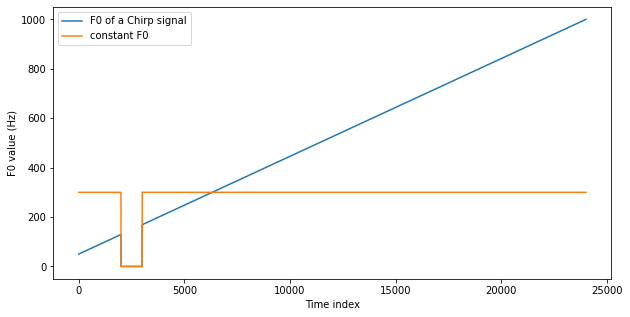

In [ ]:
import matplotlib.pyplot as plt
import plot_lib

# step.1  prepare F0 values in shape (batchsize, signal_length, dim)
#
# Here we try batchsize=2, signal_length = 3000
# try a chirp signal in the 1st batch (50 - 1000 Hz)
# try a constant F0 signal in the 2nd batch (300 Hz)
signal_length = 24000
f0_value = torch.ones(2, signal_length, 1)
f0_value[0, :, 0] = torch.linspace(50, 1000, signal_length)
f0_value[1, :, 0] = 300

# set one unvoiced segment
f0_value[:, 2000:3000, :] = 0

plt.figure()
plt.plot(f0_value[0, :, 0])
plt.plot(f0_value[1, :, 0])
plt.legend(['F0 of a Chirp signal', 'constant F0'])
plt.xlabel('Time index')
plt.ylabel('F0 value (Hz)')

print("The f0_value is a tensor of shape", str(f0_value.shape))

In [ ]:
# step2 create a generator
#
sampling_rate = 16000
# we try to generate 7 higher harmonics
harmonic_num = 7
# Additive noise standard deviation
noise_std = 0.003

# create the Pytorch module
sin_gen = SineGen(sampling_rate, harmonic_num=harmonic_num, noise_std=noise_std)

Generated sine waveforms form a tensor of shape torch.Size([2, 24000, 8])
Batch size: 2
Waveform length: 24000
Number of harmonics (including F0): 8


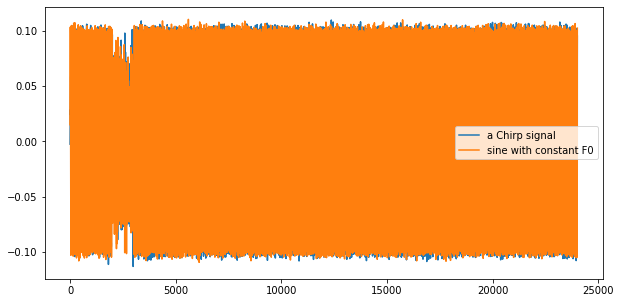

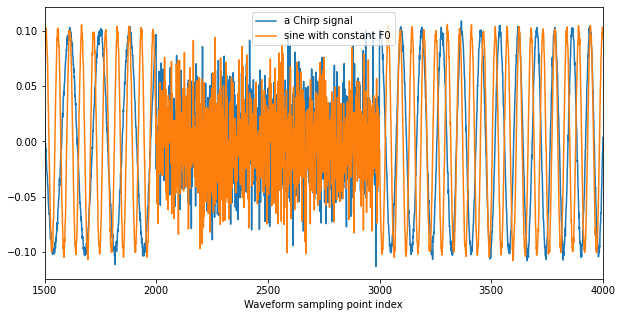

In [ ]:
# step3. generate the sine signal
sine, uv, noise = sin_gen(f0_value)

# plot the fundamental component only
plt.figure()
plt.plot(sine[0, :, 0])
plt.plot(sine[1, :, 0])
plt.legend(['a Chirp signal', 'sine with constant F0'])


# plot the fundamental component only (zoom in 1500, 4000)
plt.figure()
plt.plot(sine[0, :, 0])
plt.plot(sine[1, :, 0])
plt.legend(['a Chirp signal', 'sine with constant F0'])
plt.xlabel('Waveform sampling point index')
plt.xlim(1500, 4000);

print("Generated sine waveforms form a tensor of shape", str(sine.shape))
print("Batch size:", str(sine.shape[0]))
print("Waveform length:", str(sine.shape[1]))
print("Number of harmonics (including F0):", str(sine.shape[2]))

In [ ]:
import IPython.display
IPython.display.display("Sine waveform")
IPython.display.display(IPython.display.Audio(sine[1, :, 0], rate=sampling_rate))
IPython.display.display("Sine waveform (2nd harmonic)")
IPython.display.display(IPython.display.Audio(sine[1, :, 1], rate=sampling_rate))

IPython.display.display("Chirp waveform")
IPython.display.display(IPython.display.Audio(sine[0, :, 0], rate=sampling_rate))
IPython.display.display("Chirp waveform (F0 x2)")
IPython.display.display(IPython.display.Audio(sine[0, :, 1], rate=sampling_rate))


'Sine waveform'

'Sine waveform (2nd harmonic)'

'Chirp waveform'

'Chirp waveform (F0 x2)'

This is the end of this notebook

# License
```
BSD 3-Clause License

Copyright (c) 2022, Xin Wang, National Institute of Informatics
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

# ACKNOWLEDGEMENT
This work is partially supported by JST CREST Grants (JPMJCR18A6 and JPMJCR20D3), MEXT KAKENHI Grants (21K17775, 21H04906).